## Regression

The 'term' regression differs in common usage between econometrics and machine learning. In econometrics, a regression invloves the estimation of parameters values that relate a dependent variable to independents variables.<br>
The most common form of regression in econometrics is multiple linear regression, which involves the estimation of a linear association between a continuos dependent variable and multiple independent variables.


### Linear Regression

#### Overview

A linear regression models the relationship between a dependent variable, y, and a set of independent variables, under the assupmtion of linearity in the coefficients.[1]

[1] *There will not be a deterministic relationship between the dependent variable and independent variables, Rather, ther wil be some noise ε associated with each observation, which could arise as the result of unobserved, random differences across entities or measurement error.*


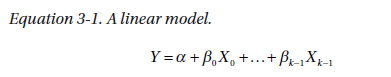



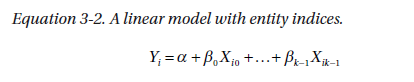

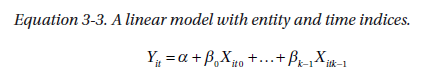

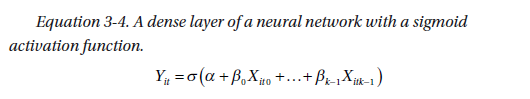

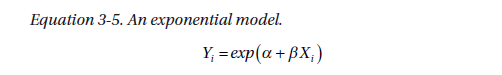

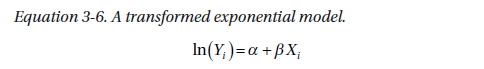

As an example of this, let's say we have data drawn from a process that is known to be non-linear, but its exact functional form in unknown. <br>
Figure 3_1 shows a scatter plot of the data, along with plots of two linear regression model.<br>
<br>

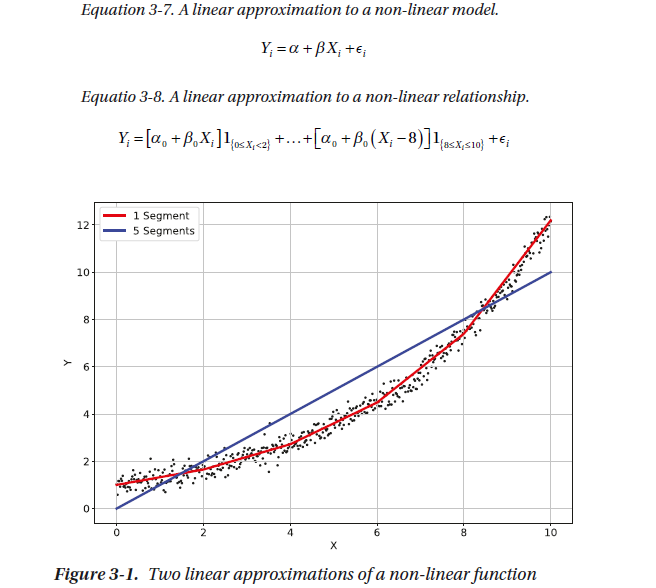

The first is trained over the assumption that the relationship  between X and Y is well aproximatted over an interval using a single line.

The second one takes the assumption that we need 5 segment lines like in equation 3-8

#### Ordinary Least Squares (OLS)

In economics the most common loss function is the sum or mean of the squared errors[2], which we will consider first.

One of the benefits of using **mse** as a loss function is that it permits an analytical solution, which means that we do not need to use time-consuming and error-prone optimization algorithms.

[2] *'mse' is the abbreviated name used in TensorFlow*

In [1]:
# Implementation of OLS in tensorFlow
import tensorflow as tf

#Define the data as constants
X = tf.constant([[1, 0],[1, 2]], tf.float32)
Y = tf.constant([[2],[4]], tf.float32)

# Compute vector of parameters
XT = tf.transpose(X)
XTX = tf.matmul(XT, X)
beta = tf.matmul(tf.matmul(tf.linalg.inv(XTX),XT),Y)

XT, XTX, beta

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1., 1.],
        [0., 2.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[2., 2.],
        [2., 4.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[2.],
        [1.]], dtype=float32)>)

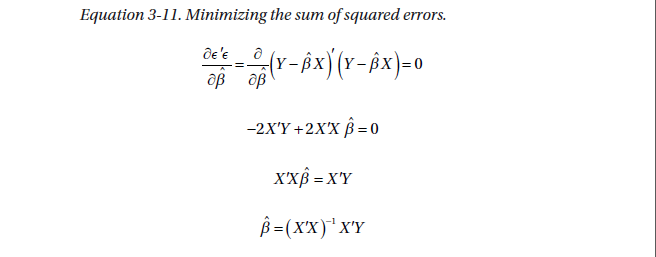

This operation in tensorflow will be interesting when we are working with bigger arrays(tensors) shapes

#### Least Absolute Deviations (LAD)

Another loss function.

With this one, we can minimize the sum of the absolute values of the errors instead, as we do in ODS, the sum of the squares

This solution dos not have an analytical solution. We 'must' search for the minimum by training or estimating the model

In [2]:
# Set a random seed
#tf.random.set_seed(37)

# Set the number of observations and samples
S = 100
N = 10000

# Set true values of parameters. Bias and slope
alpha = tf.constant([1.])
beta = tf.constant([3.])

# Draw independent variable and error
X = tf.random.normal([N,S])
epsilon = tf.random.normal([N,S], stddev=0.25)

# Compute dependent variable
Y = alpha + beta*X + epsilon
Y

<tf.Tensor: shape=(10000, 100), dtype=float32, numpy=
array([[ 2.563012  , -2.6037977 ,  7.984304  , ...,  1.5707014 ,
         2.420452  ,  5.1283484 ],
       [ 5.7868567 ,  1.8562958 ,  0.88911116, ..., -1.3997068 ,
         1.829671  , -1.7852743 ],
       [-2.350258  , -0.85884124,  1.469841  , ..., -4.0294843 ,
         0.27301633,  0.9301476 ],
       ...,
       [ 2.3454769 ,  4.1025305 ,  3.17668   , ...,  2.3512816 ,
         1.4690118 , -0.60415655],
       [ 5.73452   ,  1.0737395 , -1.386114  , ..., -0.15602031,
         3.5641584 ,  5.966212  ],
       [ 3.1121514 ,  4.186119  , -1.5591109 , ...,  1.9022101 ,
         0.47921634, -3.852653  ]], dtype=float32)>

The next step is to minimize the mean absolute error, since this has better numerical properties. [2]

To compute the mean absolute error, we define a function called maeLoss, which takes the parameters and data as inputs and outputs the associated value of the loss function.

The function first computes the error for each observation. It then transforms these values to their absolute values unsing `tfabs()` and then returns the mean across all observations using `tf.reduce_mean()`

[2] *Since the mean is the sum divided by the numer of observations, minimizing the mean will be equivalent to minimizing the sums, and, also, will take less GPU usage*

In [3]:
# Draw initial values randomly
alphaHat0 = tf.random.normal([1], stddev=5.0)
betaHat0 = tf.random.normal([1], stddev=5.0)

# Define variables
alphaHat = tf.Variable(alphaHat0, tf.float32)
betaHat = tf.Variable(betaHat0, tf.float32)

# Define function to compute "mae" loss
def maeLoss(alphaHat, betaHat, xSample, ySample):
  prediction = alphaHat + betaHat*xSample
  error = ySample -prediction
  absError = tf.abs(error)
  return tf.reduce_mean(absError)


The final step is to perform optimization

1. Create an instance of the Stochastic Gradient Descent `tf.optimizers.SGD()`.
2. Pass the parameters `alphaHat` and `betaHat`, and the first sample of input data, `X[:,0]`and `Y[0:]`,to `maeLoss()`
3. Pass a list of trainable variables, `var_List`, to `minimize()`. Each increment of the loop performs a minimization step, which updates the parameters and the state of the optimizer.

In [4]:
# Define optimizer
opt = tf.optimizers.SGD()

# Define an empty list to hold parameter values
alphaHist, betaHist = [], []

for i in range(1000):
    with tf.GradientTape() as tape:
        loss = maeLoss(alphaHat, betaHat, X[:, 0], Y[:, 0])
        gradients = tape.gradient(loss, [alphaHat, betaHat])
        opt.apply_gradients(zip(gradients, [alphaHat, betaHat]))

    alphaHist.append(alphaHat.numpy()[0])
    betaHist.append(betaHat.numpy()[0])



👁️👁️👁️ **ERRATA**. In the book the code is like this:
  ```
# Define optimizer
opt = tf.optimizers.SGD()

# Define an empty list to hold parameter values
alphaHist, betHist = [], []

for i in range(1000):
    opt.minimize(lambda: maeLoss(alphaHat, betaHat, X[:,0, Y[:,0]), var_list = [alphaHat, betaHat]
    )
    alphaHist.append(alphaHat.numpy()[0])
    betHist.append(betaHat.numpy()[0])

  ```

  In TensorFlow, the minimize function is used in the context of an optimizer to update the model's trainable variables (parameters) based on the calculated gradients of a specified loss function. The var_list parameter is used to explicitly specify which variables should be updated during optimization.

  In this particular case, we are using a custom loss function, and we want to compute gradients using a gradient tape.

  
  **If not, the code returns us an ERROR**

Plot the values of `alphaHat` and `betHat` at each step in the minimization process

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = np.array([alphaHist,betaHist])
data = tf.transpose(data)
data

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[-5.091998 ,  2.6654334],
       [-5.0819983,  2.6654873],
       [-5.0719986,  2.6655412],
       ...,
       [ 0.995184 ,  2.9974768],
       [ 0.995184 ,  2.997477 ],
       [ 0.995184 ,  2.9974773]], dtype=float32)>

In [6]:
# Define DataFrame of parameter histories
params = pd.DataFrame(data, columns = ['alphaHat','betaHat'])

params


,alphaHat,betaHat
0,-5.091998,2.665433
1,-5.081998,2.665487
2,-5.071999,2.665541
3,-5.061999,2.665595
4,-5.051999,2.665649
...,...,...
995,0.995184,2.997476
996,0.995184,2.997477
997,0.995184,2.997477
998,0.995184,2.997477


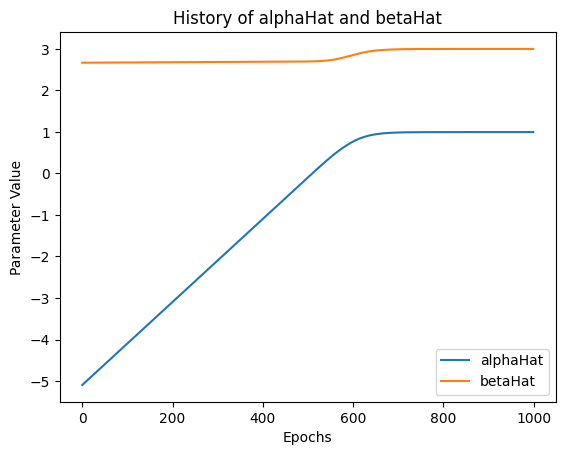

In [7]:
# Create a line plot of the alphaHat values against the index
plt.plot(params.index, params['alphaHat'], label='alphaHat')

# Create a line plot of the betaHat values against the index
plt.plot(params.index, params['betaHat'], label='betaHat')

# Add labels and title to the plot
plt.xlabel('Epochs')
plt.ylabel('Parameter Value')
plt.title('History of alphaHat and betaHat')
plt.legend()
plt.show()

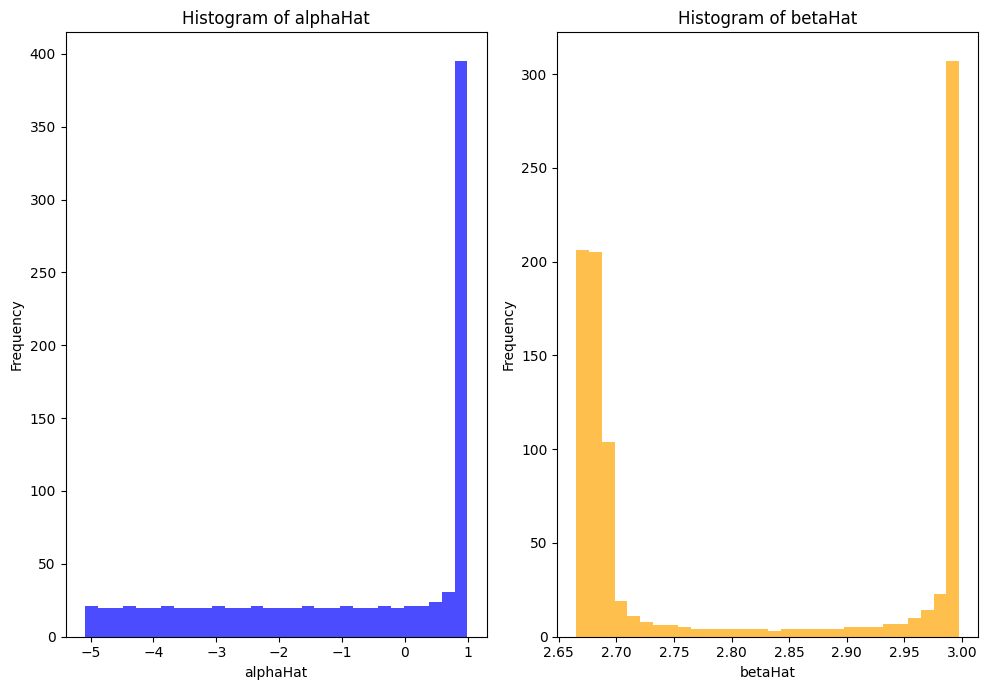

In [8]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)  # Subplot for alphaHat histogram
plt.hist(params['alphaHat'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of alphaHat')
plt.xlabel('alphaHat')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # Subplot for betaHat histogram
plt.hist(params['betaHat'], bins=30, color='orange', alpha=0.7)
plt.title('Histogram of betaHat')
plt.xlabel('betaHat')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Partially Linear Models

Model that allows for certain independent variables to enter linearly, while others are permitted to enter the model trough a non-linear function.

*In the context of econometric applications, a partially linear model would usually consists of a single variable of interest, which enters linearly. the objective of such an exercise would be to perform inference on the paramater that enters linearly.*

Let's construct  and train of a partially linear model for predictive purposes, rather than for statistical inference.

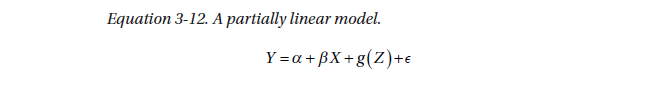

In order to perform the Monte Carlo experiment, we’ll need to make specific assumptions about the values of the linear parameters, as well
as the functional form of g(). For the sake of simplicity, we’ll assume that there is only one variable of interest, X, and one control, Z, which enters with the functional form exp(θZ). Additionally, the true parameter values are assumed to be α = 1, β = 3, and θ = 0.05.

In [9]:
# Set number of observations and samples
S = 100
N = 10000

# Set true values of parameters
alpha = tf.constant([1.], tf.float32)
beta = tf.constant([3.], tf.float32)
theta = tf.constant([0.05], tf.float32)

# Draw independent variable and error
X = tf.random.normal([N, S])
Z = tf.random.normal([N, S])
epsilon = tf.random.normal([N, S], stddev=0.25)

# Compute dependent variable
Y = alpha + beta*X + tf.exp(theta*Z) + epsilon

In this case, rather than computing the loss function immediately, a function is defined for the partially linear model, which takes the parameters and a sample of the data as inputs and then outputs a prediction for each observation.

In [10]:
# Draw initial values randomly.
alphaHat0 = tf.random.normal([1], stddev=5.0)
betaHat0 = tf.random.normal([1], stddev=5.0)
thetaHat0 = tf.random.normal([1], mean=0.05, stddev=0.10)

# Define variables.
alphaHat = tf.Variable(alphaHat0, tf.float32)
betaHat = tf.Variable(betaHat0, tf.float32)
thetaHat = tf.Variable(thetaHat0, tf.float32)

# Compute prediction.
def plm(alphaHat, betaHat, thetaHat, xS, zS):
  prediction = alphaHat + betaHat*xS + tf.exp(thetaHat*zS)
  return prediction

This time, instead of computing MAE manually, we use TensorFlow operation `tf.losses.mae()`


In [11]:
# Define function to compute MAE loss.
def maeLoss(alphaHat, betaHat, thetaHat, xS, zS, yS):
  yHat = plm(alphaHat, betaHat, thetaHat, xS, zS)
  return tf.losses.mae(yS, yHat)

In [12]:
# Instantiate optimizer.
opt = tf.optimizers.SGD()

# Define an empty list to hold parameter values
alphaHist, betaHist, thetaHist = [], [], []

# Perform optimization.
for i in range(1000):
  opt.minimize(lambda: maeLoss(alphaHat, betaHat, thetaHat, X[:,0], Z[:,0], Y[:,0]),
  var_list = [alphaHat, betaHat, thetaHat])

  alphaHist.append(alphaHat.numpy()[0])
  betaHist.append(betaHat.numpy()[0])
  thetaHist.append(thetaHat.numpy()[0])

In [13]:
data = np.array([alphaHist,betaHist,thetaHist])
data = tf.transpose(data)
data

<tf.Tensor: shape=(1000, 3), dtype=float32, numpy=
array([[5.1369686 , 6.639768  , 0.1204048 ],
       [5.1295547 , 6.635545  , 0.11942711],
       [5.1221447 , 6.631317  , 0.11846139],
       ...,
       [1.0044501 , 3.0011458 , 0.04624885],
       [1.0044501 , 3.0011485 , 0.04624592],
       [1.0044501 , 3.0011468 , 0.04624794]], dtype=float32)>

In [14]:
# Define DataFrame of parameter histories
params = pd.DataFrame(data, columns = ['alphaHat','betaHat','thetaHat'])

params


,alphaHat,betaHat,thetaHat
0,5.136969,6.639768,0.120405
1,5.129555,6.635545,0.119427
2,5.122145,6.631317,0.118461
3,5.114735,6.627090,0.117503
4,5.107335,6.622851,0.116548
...,...,...,...
995,1.004450,3.001145,0.046250
996,1.004450,3.001148,0.046247
997,1.004450,3.001146,0.046249
998,1.004450,3.001148,0.046246


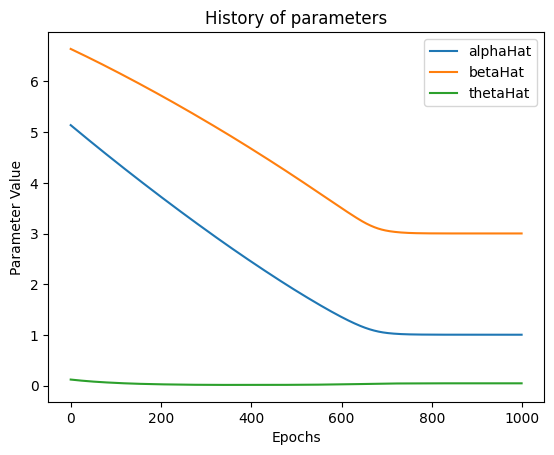

In [15]:
# Create a line plot of the alphaHat values against the index
plt.plot(params.index, params['alphaHat'], label='alphaHat')

# Create a line plot of the betaHat values against the index
plt.plot(params.index, params['betaHat'], label='betaHat')

# Create a line plot of the thetaHat values against the index
plt.plot(params.index, params['thetaHat'], label='thetaHat')

# Add labels and title to the plot
plt.xlabel('Epochs')
plt.ylabel('Parameter Value')
plt.title('History of parameters')
plt.legend()
plt.show()

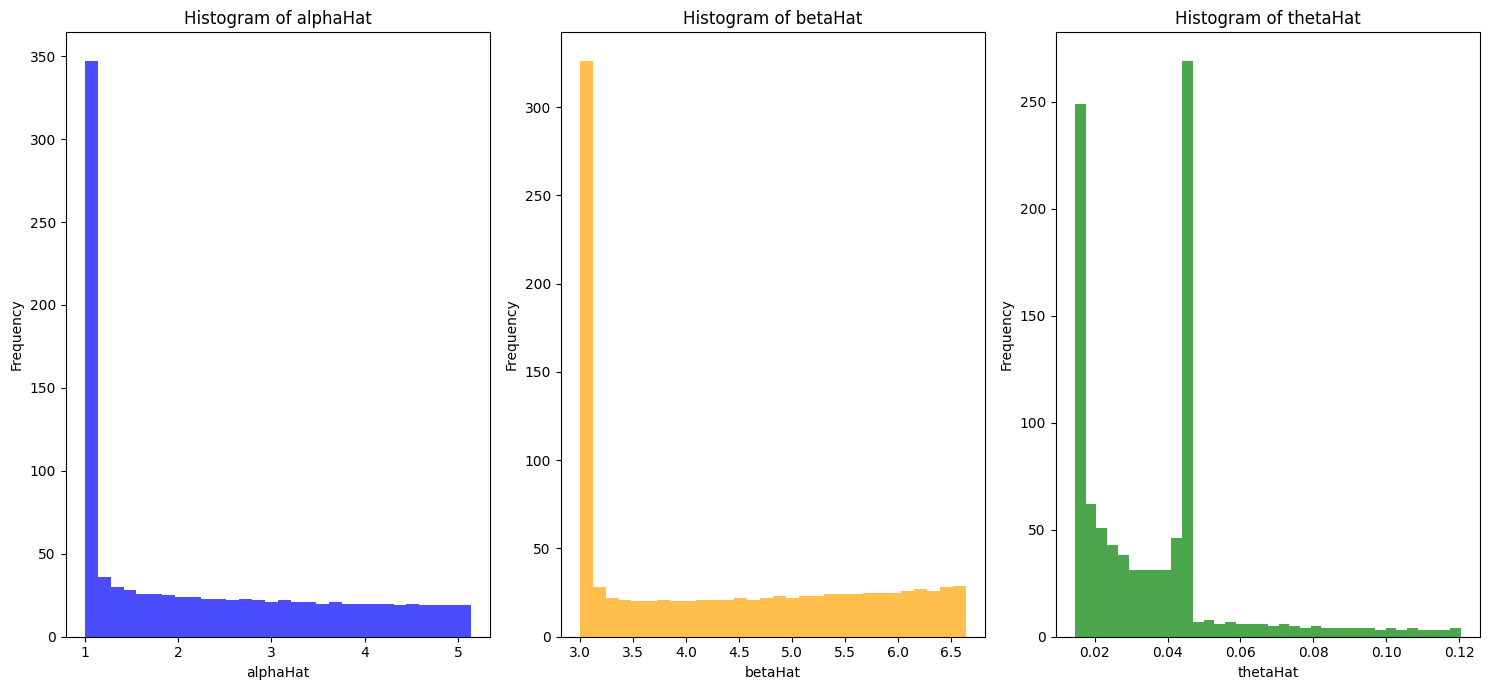

In [19]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 3, 1)  # Subplot for alphaHat histogram
plt.hist(params['alphaHat'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of alphaHat')
plt.xlabel('alphaHat')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)  # Subplot for betaHat histogram
plt.hist(params['betaHat'], bins=30, color='orange', alpha=0.7)
plt.title('Histogram of betaHat')
plt.xlabel('betaHat')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)  # Subplot for betaHat histogram
plt.hist(params['thetaHat'], bins=36, color='green', alpha=0.7)
plt.title('Histogram of thetaHat')
plt.xlabel('thetaHat')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Non-linear Regression

Solving a fully non-linear model can be accomplished using the same workflow as the partially linear model.

Rather tha generate data, we´ll make use of the natural logarithm of the daily exchange rate for USD and GBP.

[DEXUSUK](https://fred.stlouisfed.org/series/DEXUSUK)

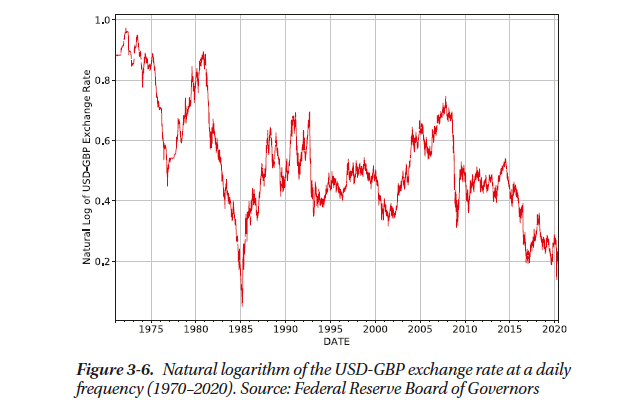

Since exchange rates are challenging to predict, a random walk is often used as the benchmark model in forecasting exercises.

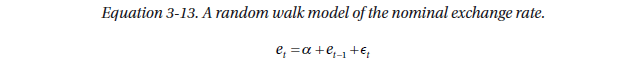

Threshold autoregressive (TAR) models could generate improvements over the random walk model.

In this exercise we will focus on implementing a TAR model in TensorFlow using the nominal, rather than real, exchange rate.

An autoregressive model assumes that movements in a series are explained by past values of the series and noise.

A TAR model modifies an autoregression by allowing parameter values to vary according to pre-defined thresholds. That is, parameters are assumed to be fixed within a particular regime, but may vary across regimes.

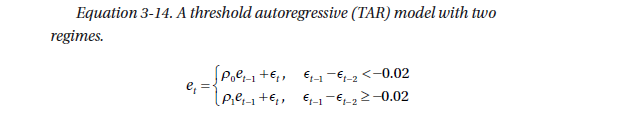

In [20]:
# Connect Colab con Google Drive to get the file with the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
